<hr>
<h2 style="text-align: center;">Geo-Sat image processing</h2>
<hr>

**Author:** Viveksharma Prabhakara<br>
**Date:** June 1, 2025<br>
**Description:**<br>
This script explores a geosat data and does image processing to: <br>1) segment a fused tif image into their respective bands<br>
2) Compute the spatial shifts between consecutive images in a band and aligns them into a mosaic<br>
3) Further, creates an RGB composite to create an ovelay

In [1]:
import sys
sys.path.append('./utils/')
import os
from utils import io, config
from utils import image_processing as imp
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import cv2

%load_ext autoreload
%autoreload 2

dataFolder = Path(os.environ.get("GEOSATDATA_PATH"))
if not dataFolder:
    print(f"[ERROR]: Set the path to the data folder in the environment variables")


## File segmentation:
Read the tiff file and segment the array based on bands. Tiff separation is prior known and configures in the config.py

In [2]:
dataPath = dataFolder.joinpath("image_003711.tiff") # visualize the first image
print(dataPath)
data = io.GeoFileData()
data.ReadFile(str(dataPath))

C:\Users\vivek\Documents\github\GeoSat-image-processing\data\Kaleideo IPS Dataset\image_003711.tiff


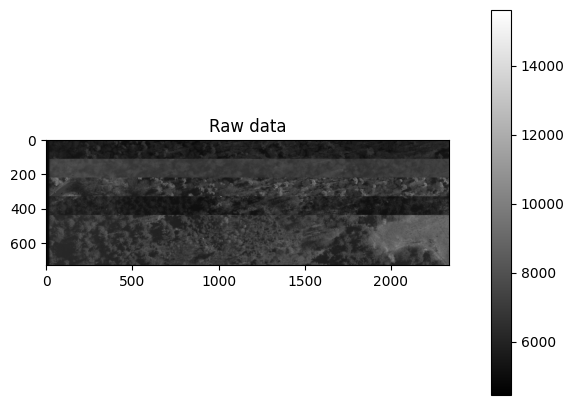

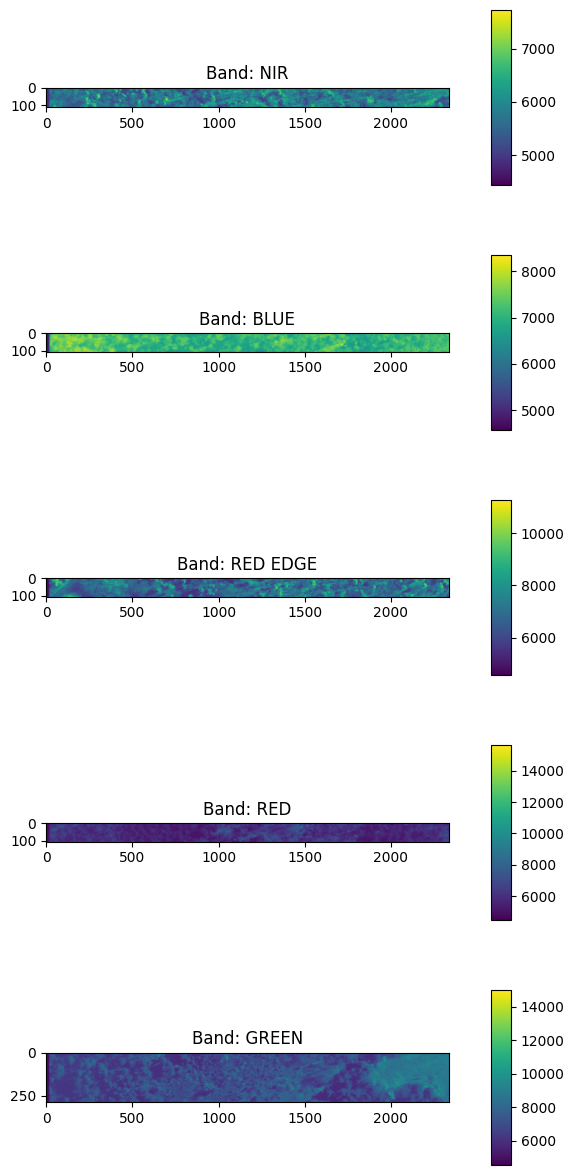

In [3]:
#Visualize the data
data.DataPlainView()

## Registration of bands across multiple frames 
First lets visualize how the data looks across multiple frames

In [4]:
bandNumber = -1 # last band number {GREEN} is used to determine shift as it is the PAN band with most intensity
imgAlignStrategy = imp.ImageAlignmentStrategy(imp.PhaseCorrelation(), dataFolder) # set the strategy to align images
rawData = imgAlignStrategy.GetRawData(bandNumber = bandNumber)
 

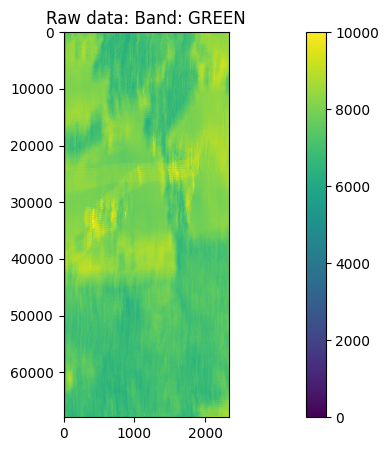

In [5]:
plt.figure(figsize = (20,5))
plt.imshow(np.flipud(rawData), aspect= 0.08)
plt.clim([0,10000])
plt.colorbar()
plt.title(f"Raw data: Band: {config.BAND_NAMES[bandNumber]}")
plt.show()


# Image alignment

Phase correlation is used to determine the shift between the frames. Phase correlation is a lightweight algorithm and adaptable for realtime processing, that works in Fourier space and is pretty handy when the problem statement is limited to finding the linear translation between frames, given the frames are captured under the same modality. Below shows an example of registering a fixed and a moving image. The moving image is aligned to fixed with phase correlation and zero padding is added to accomodate shifts that are beyond the image boundaries.

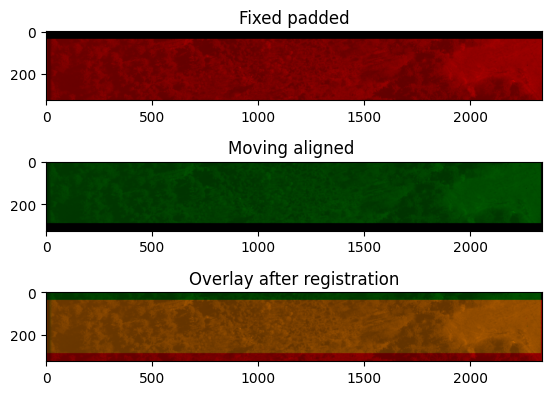

In [6]:
dataIter = io.LoadBulkData(dataFolder, '*.tiff')
fixed = next(dataIter)
moving = next(dataIter)
fixedData = fixed.data[bandNumber].astype(np.float32)
movingData = moving.data[bandNumber].astype(np.float32)

# Determine shift and align two images for example
shift, response = imgAlignStrategy.registrationManager.Register(fixedData, movingData)
paddingProps, fixedPadded, alignedPadded = imgAlignStrategy.AlignFixedAndMoving(fixedData, movingData, shift)
imgAlignStrategy.VisualizeOverlapArea(fixedPadded,alignedPadded)

Now determine the shifts for all consecutive frames and align them on top of each other.

In [7]:
intraAlignedBands = imgAlignStrategy.AlignImages()

[INFO]: Aligning images


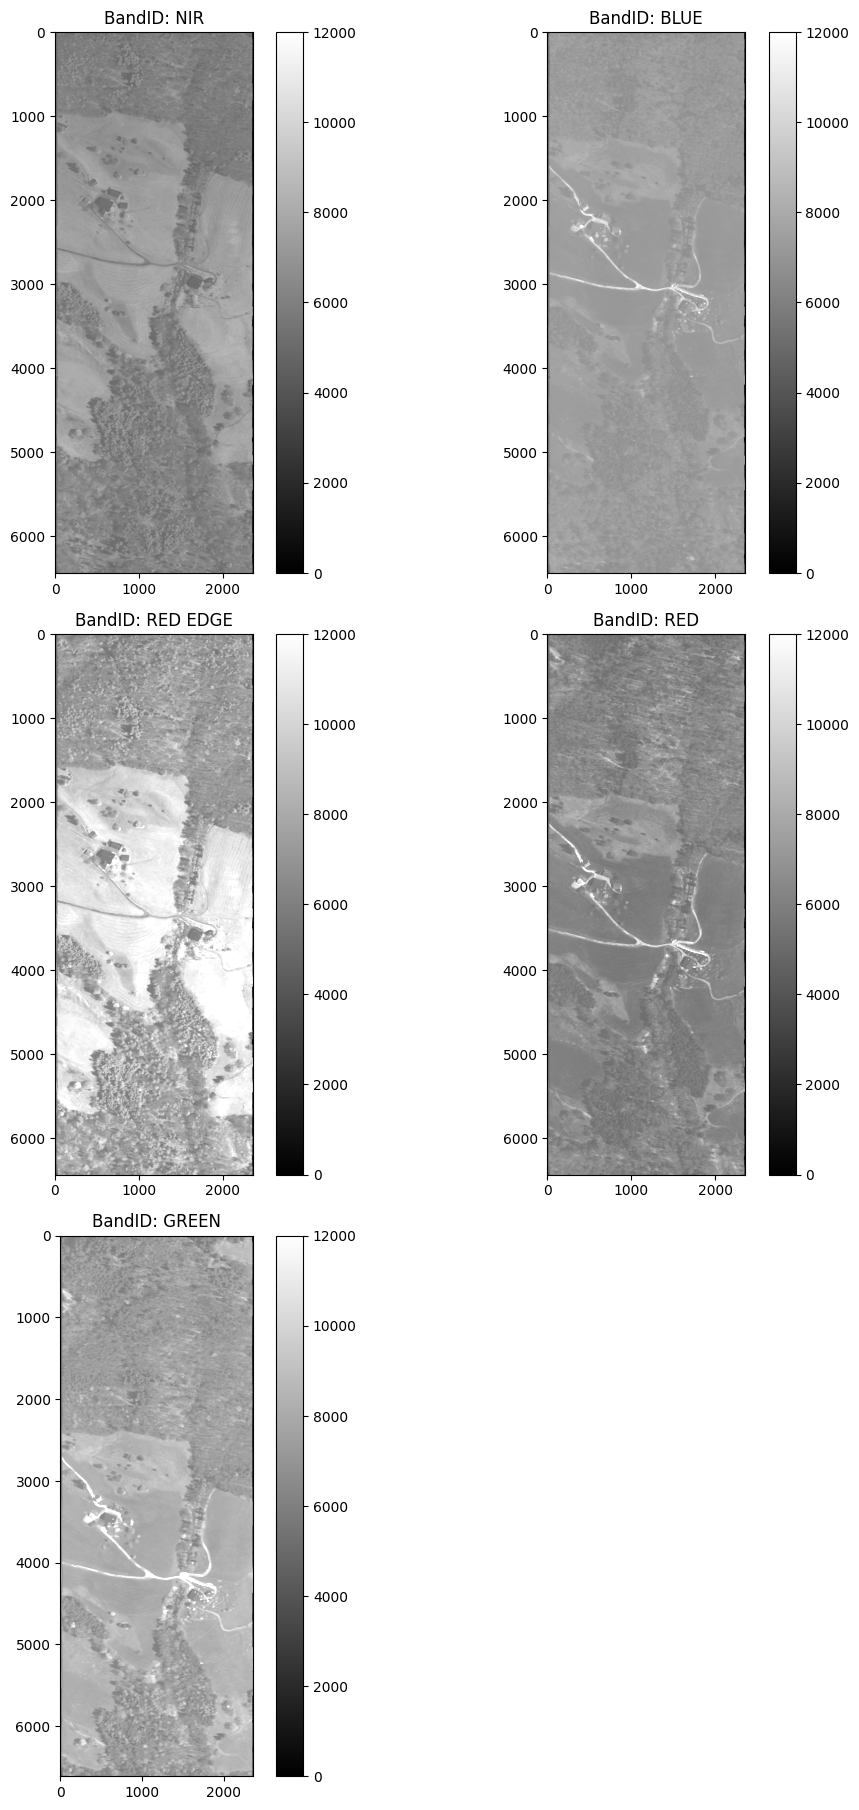

In [8]:
# Visualize aligned bands
plt.figure(figsize = (10,30))
for bandId in range(config.GEOTIFFIMAGE_BANDS):
    plt.subplot(config.GEOTIFFIMAGE_BANDS, config.GEOTIFFIMAGE_BANDS//2, bandId+1)
    plt.imshow(intraAlignedBands[bandId], cmap = 'gray')
    plt.clim([0,1.2E4])
    plt.title(f"BandID: {config.BAND_NAMES[bandId]}")
    plt.colorbar()
    plt.tight_layout()
plt.show()

Small subset visualization

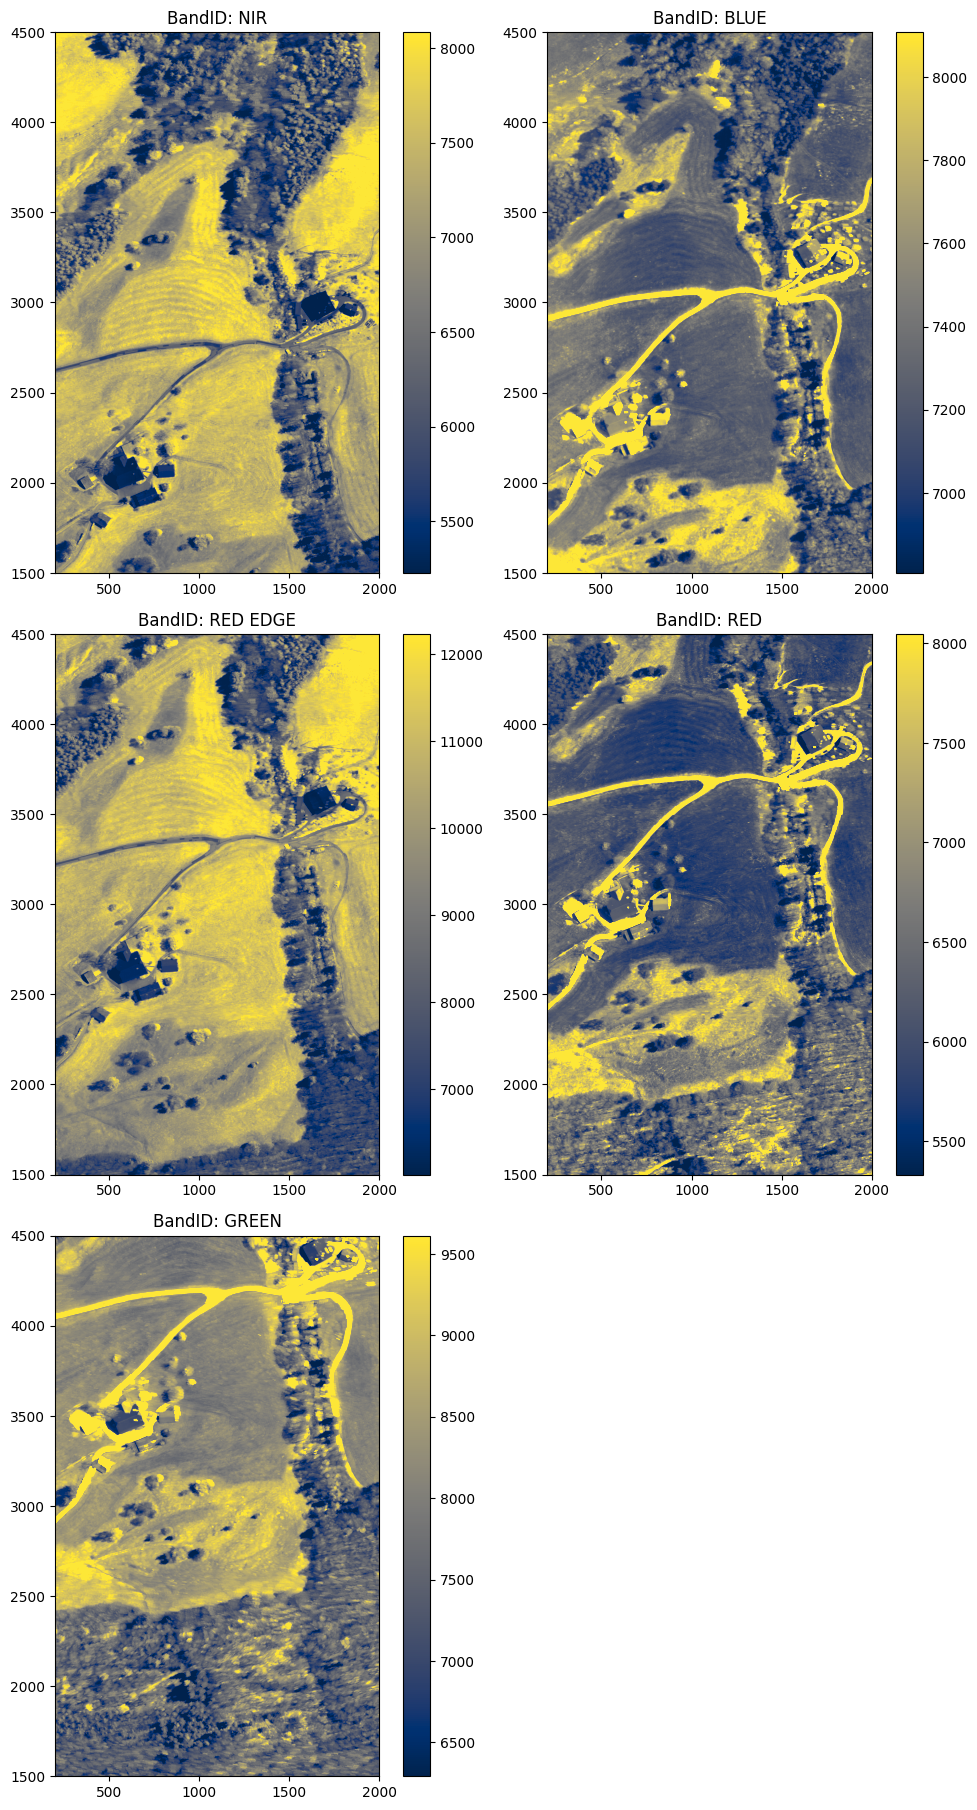

In [9]:
# Visualize aligned bands
def VisualizeBandsSmallSubset(bandData):
    plt.figure(figsize = (10,30))
    for bandId in range(len(bandData)):
        plt.subplot(len(bandData), len(bandData)//2, bandId+1)
        plt.imshow(bandData[bandId], cmap = 'cividis')
        plt.clim([np.percentile(bandData[bandId], 3),np.percentile(bandData[bandId], 97)])
        plt.xlim([200,2000])
        plt.ylim([1500,4500])
        plt.title(f"BandID: {config.BAND_NAMES[bandId]}")
        plt.colorbar()
        plt.tight_layout()
    plt.show()

VisualizeBandsSmallSubset(intraAlignedBands)

### SNR normalization
Normalize SNR of all bands to the panband. SNR = standard_deviation/ mean..
scale factor = Target_SNR(PAN)/ band_SNR

In [10]:
intraBandAlignedDataSNRNorm = imp.NormalizeSNR(intraAlignedBands, panBandData = intraAlignedBands[-1])

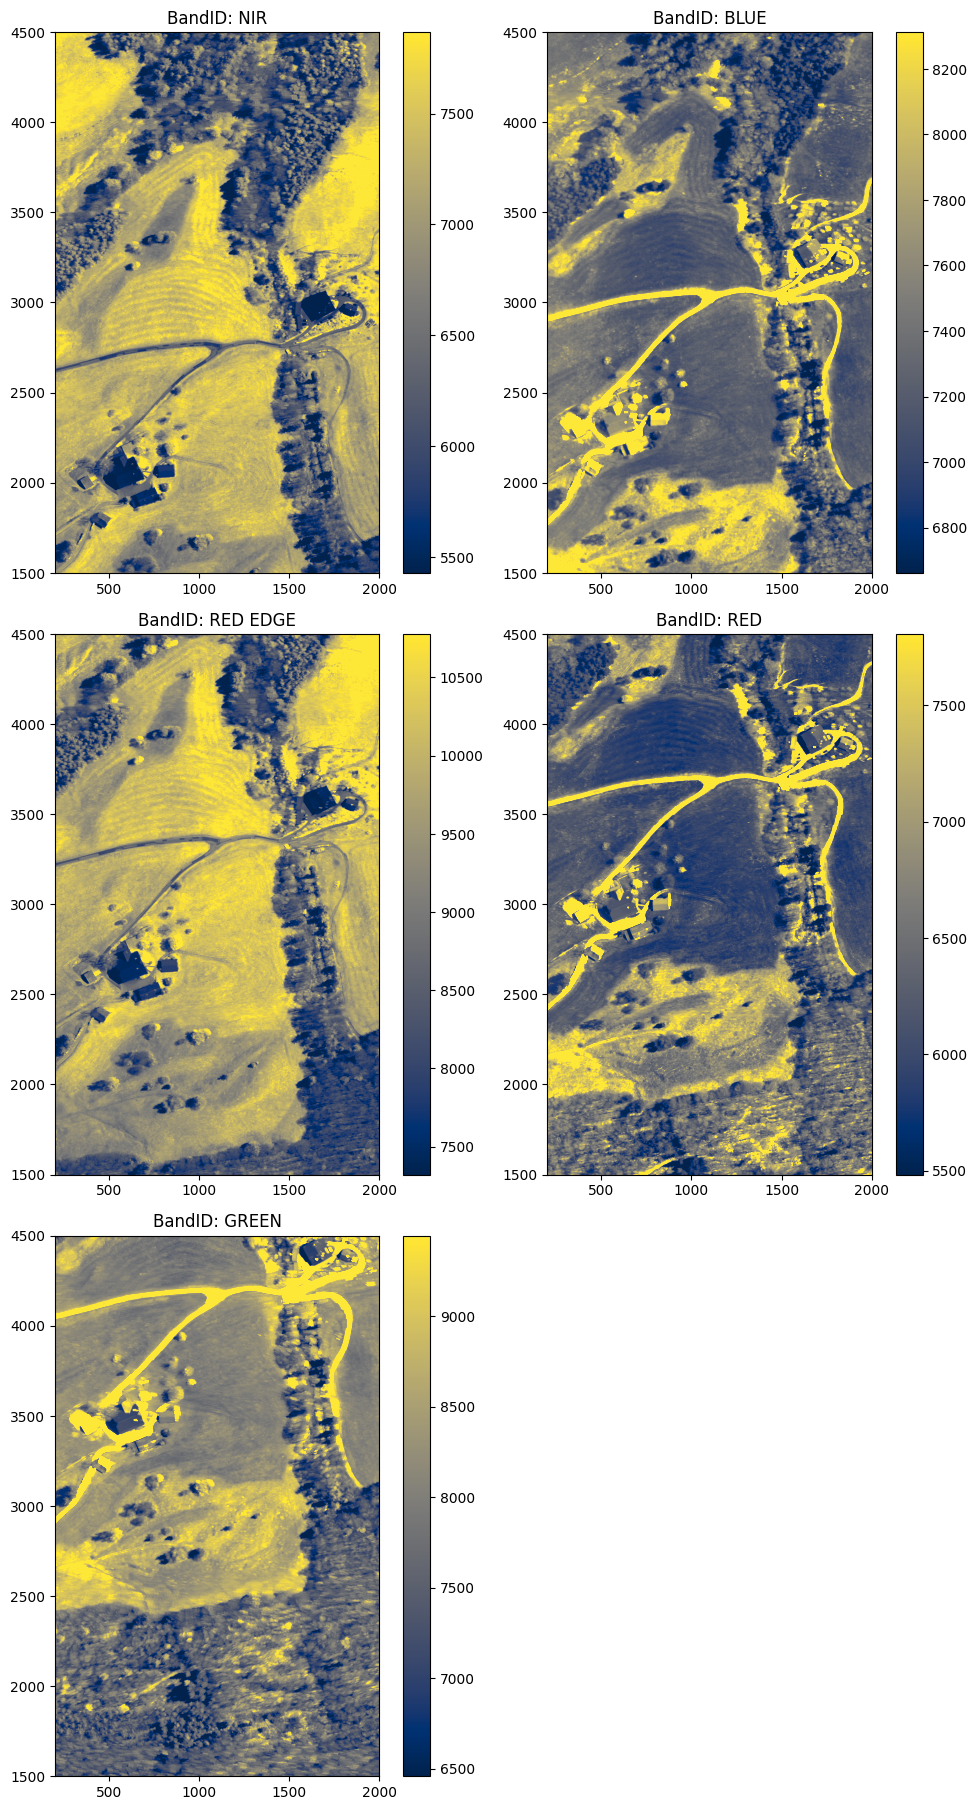

In [11]:
VisualizeBandsSmallSubset(intraBandAlignedDataSNRNorm)

Fuse RGB bands to create a composite by fusing or across bands' alignment using ORB feature descriptors and hamming distance mapping.

Text(0.5, 1.0, 'RGB bands fused')

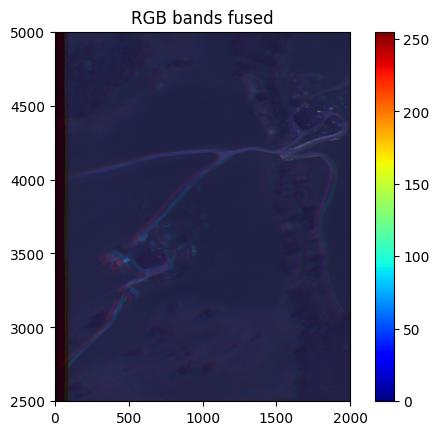

In [12]:

crossAlignedBands = imp.CrossBandsAlign(intraBandAlignedDataSNRNorm)

# Extract the RGB band and create a composite
rgbComposite = []
for band in ["RED", "GREEN", "BLUE"]:
    bandData = cv2.normalize(crossAlignedBands[config.BANDS[band]], None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    rgbComposite.append(bandData)

rgbComposite = np.stack(rgbComposite, axis = -1)
plt.imshow( rgbComposite, cmap = 'jet')
plt.ylim([2500,5000])
plt.xlim([0,2000])
plt.colorbar()
plt.title("RGB bands fused")
